# MAPseq Data Analysis

In this notebook, we will take the combined bulk RNAseq from all MAPseq target areas. 

## Imports

In [4]:
import logging
import os
import sys
from configparser import ConfigParser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for handling barcode tags with letters and numbers. 
from natsort import natsorted

# Allowing to run from git. 
gitpath=os.path.expanduser("~/git/mapseq-processing")
sys.path.append(gitpath)

gitpath=os.path.expanduser("~/git/cshlwork")
sys.path.append(gitpath)

from mapseq.core import * 
from cshlwork.utils import dataframe_to_seqlist, write_fasta_from_df, run_command_shell, NonZeroReturnException, setup_logging
from alignment.bowtie import run_bowtie, make_bowtie_df, make_adjacency_df

print("Done")

Done


## Configuration, logging, and paths for analysis
We need to provide paths to the two fastq read files (either fastq or fastq.gz), the barcode (SSI) sequences for different target areas, and a standard sample info Excel spreadsheet. 


In [6]:
cp = get_default_config()
logging.getLogger().setLevel(logging.INFO)
sampleinfo = os.path.expanduser('~/project/mapseq/M205test/Mseq205_sampleinfo.xlsx')
barcodes = os.path.expanduser('~/project/mapseq/M205test/barcode_v2.txt')
outdir = os.path.expanduser('~/project/mapseq/M205jupout')
infiles = [
    os.path.expanduser('~/project/mapseq/M205test/M205_HZ_S1_R1_001.fastq.gz'),
    os.path.expanduser('~/project/mapseq/M205test/M205_HZ_S1_R2_001.fastq.gz')
          ]

In [7]:
sampdf = load_sample_info(cp, sampleinfo)
# extract list of actually used primers.
rtlist = list(sampdf.rtprimer.dropna())
# make barcode handler objects
bcolist = load_barcodes(cp, barcodes, labels=rtlist, outdir=outdir)
print(len(bcolist))
sampdf = sampdf[sampdf['rtprimer'].notna()]
of = f'{outdir}/sampleinfo.tsv'
sampdf.to_csv(of, sep='\t')
sampdf

26


,usertube,ourtube,samplename,siteinfo,rtprimer,brain,col_num
1,OB,1,Olfactory Bulb,NaN,1,YW143,1
2,ACB,2,ACB,NaN,2,YW143,2
3,AI,3,AI,NaN,3,YW143,3
4,CP,4,CP (dorsal part - can just dissect out the top...,NaN,4,YW143,4
5,MTN,5,MTN,NaN,5,YW143,5
6,BLAa,6,BLAa,NaN,6,YW143,6
7,PIR,7,Piriform Cortex,NaN,7,YW143,7
8,VTA,8,VTA,NaN,8,YW143,8
9,TeA,9,TeA,NaN,9,YW143,9
10,ENTl,10,ENTl,NaN,10,YW143,10


In [8]:
# handle all the input. usually takes ~25 minutes
process_fastq_pair(cp, infiles[0], infiles[1], bcolist, outdir=outdir, force=False)
!ls ~/project/mapseq/M205jupout/

2023-03-20 20:21:14,166 (UTC) [ INFO ] core.py:596 root.check_output(): all output exists.
2023-03-20 20:21:14,166 (UTC) [ INFO ] core.py:607 root.process_fastq_pair(): output_exists=True force=False
2023-03-20 20:21:14,167 (UTC) [ INFO ] core.py:677 root.process_fastq_pair(): all output exists and force=False. Not recalculating.


BC1.fasta          BC17.fasta         BC24.fasta         BC5.fasta
BC1.tsv            BC17.tsv           BC24.tsv           BC5.tsv
BC10.fasta         BC18.fasta         BC25.fasta         BC6.fasta
BC10.tsv           BC18.tsv           BC25.tsv           BC6.tsv
BC11.fasta         BC19.fasta         BC26.fasta         BC7.fasta
BC11.tsv           BC19.tsv           BC26.tsv           BC7.tsv
BC12.fasta         BC2.fasta          BC3.fasta          BC8.fasta
BC12.tsv           BC2.tsv            BC3.real.bowtie    BC8.tsv
BC13.fasta         BC20.fasta         BC3.real.seq.fasta BC9.fasta
BC13.tsv           BC20.tsv           BC3.tsv            BC9.tsv
BC14.fasta         BC21.fasta         BC4.32.fasta       indexes
BC14.tsv           BC21.tsv           BC4.fasta          paired.txt
BC15.fasta         BC22.fasta         BC4.lone.tsv       sampleinfo.tsv
BC15.tsv           BC22.tsv           BC4.real.tsv       unmatched.fasta
BC16.fasta         BC23.fasta         BC4.spike.tsv
BC16.tsv  

In [14]:
dflist = []
for bch in bcolist:
    filepath = os.path.abspath(bch.filename)    
    dirname = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    (base, ext) = os.path.splitext(filename)
    of = f'{dirname}/{base}.tsv'
    seqdf = make_fasta_df(cp, bch.filename)
    cdf = make_counts_df(cp, seqdf, bc_label=bch.label)  
    threshold = calculate_threshold(cp, cdf)
    tdf = threshold_counts(cp, cdf)
    tdf['counts'] = 1
    tdf['sequence'] = tdf['sequence'].str[:32]
    bch.dataframe = make_counts_df(cp, tdf)
    dflist.append(tdf)
alldf = BarCodeHandler.merge_counts(cp, dflist)
alldf['logcounts'] = np.log(alldf.counts)
alldf 

2023-03-20 20:51:05,666 (UTC) [ INFO ] core.py:320 root.make_fasta_df(): kept 7341 sequences out of 7342
2023-03-20 20:51:05,676 (UTC) [ INFO ] core.py:367 root.threshold_counts(): thresh = 2
2023-03-20 20:51:06,946 (UTC) [ INFO ] core.py:320 root.make_fasta_df(): kept 160425 sequences out of 160429
2023-03-20 20:51:07,072 (UTC) [ INFO ] core.py:367 root.threshold_counts(): thresh = 2
2023-03-20 20:51:07,386 (UTC) [ INFO ] core.py:320 root.make_fasta_df(): kept 32485 sequences out of 32485
2023-03-20 20:51:07,414 (UTC) [ INFO ] core.py:367 root.threshold_counts(): thresh = 2
2023-03-20 20:51:12,127 (UTC) [ INFO ] core.py:320 root.make_fasta_df(): kept 603075 sequences out of 603096
2023-03-20 20:51:12,604 (UTC) [ INFO ] core.py:367 root.threshold_counts(): thresh = 2
2023-03-20 20:51:14,631 (UTC) [ INFO ] core.py:320 root.make_fasta_df(): kept 238904 sequences out of 238914
2023-03-20 20:51:14,809 (UTC) [ INFO ] core.py:367 root.threshold_counts(): thresh = 2
2023-03-20 20:51:15,732 (U

,bc_label,sequence,counts,logcounts
0,BC1,GCTTTACTAAACTCTTCCTTGCCATTGAATTC,1,0.0
1,BC1,AACACCAGCAAGTGGAGGGTTATGCGCGTACT,1,0.0
2,BC1,ATTCTCAGGTAAATGGCGCCGCTTAATTTATC,1,0.0
3,BC1,GTTTCACCCGGTCTGCACGCGCCAGCCACCCG,1,0.0
4,BC1,CTGGAGCTGCGATGTCGTTAACGCCGTCAGTC,1,0.0
...,...,...,...,...
3539371,BC26,TAGCATATTCGGTTGTTGCTCTAACGTCAGTC,1,0.0
3539372,BC26,GGTCTGACACGGGACGCGTGAGGTCGTCAGTC,1,0.0
3539373,BC26,CTACCCTAGCGCGGCGAGTATCCCCGTCAGTC,1,0.0
3539374,BC26,GAGGGAGTCAAAGGGCTGAGGTACCTCCCATC,1,0.0


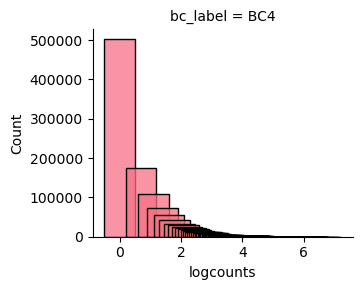

In [175]:
graph = sns.FacetGrid(alldf, col = 'bc_label', hue='counts', col_wrap = 4, row_order='bc_label')
graph.map(sns.histplot, "logcounts")
plt.show()

In [12]:
# use BC4  as example 
# need to trim again to 32 length!!

reals =[]
spikes =[]
lones =[]

for bch in bcolist:
#bch = bcolist[0]
    outfile = trim_fasta(cp, bch.filename, length=32)
    df = make_counts_df(cp, outfile, bc_label=bch.label)
    bch.dataframe = df
    print(f'{bch.label} {len(df)}')
    (spikedf, realdf, lonedf) = split_spike_real_lone_barcodes(cp, df)

    realcdf = make_counts_df(config, realdf)
    spikecdf = make_counts_df(config, spikedf)
    lonecdf = make_counts_df(config, lonedf)    
    
    acrealdf = align_and_collapse(config, realdf, dirname, base, 'real')
    acspikedf = align_and_collapse(config, spikedf, dirname, base, 'spike')
    aclonedf = align_and_collapse(config, lonedf, dirname, base, 'lone')
    
    acrealdf['type'] = 'real'
    acspikedf['type'] = 'spike'
    aclonedf['type'] = 'lone'
    
    outdf = merge_dfs([ acrealdf, acspikedf, aclonedf ])
    outdf['bc_label'] = base
    outdf.sort_values(by = ['type', 'counts'], ascending = [True, False], inplace=True)
    outdf.reset_index(drop=True, inplace=True)    

    
    


#print(reals[0])

2023-03-20 20:49:07,501 (UTC) [ INFO ] core.py:345 root.trim_fasta(): wrote 603096 to /Users/jhover/project/mapseq/M205jupout/BC4.32.fasta


AttributeError: 'str' object has no attribute 'sequence'

In [170]:
bch = bcolist[3]
print(bch.label)
base = 'BC3'
aligner = cp.get('bcfasta','tool')
of = os.path.join(outdir , f'{base}.real.seq.fasta')
logging.debug(f'make fasta for {aligner} = {of}') 
seqfasta = write_fasta_from_df(cp, realdf, outfile=of)
of = os.path.join(outdir , f'{base}.real.{aligner}')
afile = run_bowtie(cp, seqfasta, of, tool=aligner )  
btdf = make_bowtie_df(afile)
btdf

BC4


2023-03-17 14:07:09,442 (UTC) [ INFO ] utils.py:632 root.dataframe_to_seqlist(): made list of 46225 SeqRecords
2023-03-17 14:07:09,596 (UTC) [ INFO ] bowtie.py:35 root.run_bowtie(): running allxall bowtie on /Users/jhover/project/mapseq/M205jupout/BC3.real.seq.fasta -> /Users/jhover/project/mapseq/M205jupout/BC3.real.bowtie
2023-03-17 14:07:09,598 (UTC) [ INFO ] bowtie.py:60 root.run_bowtie(): running ['bowtie-build', '/Users/jhover/project/mapseq/M205jupout/BC3.real.seq.fasta', '/Users/jhover/project/mapseq/M205jupout/indexes/BC3.real.seq']
2023-03-17 14:07:11,980 (UTC) [ INFO ] bowtie.py:68 root.run_bowtie(): bowtie-build done.
2023-03-17 14:07:12,379 (UTC) [ INFO ] bowtie.py:104 root.run_bowtie(): bowtie done.


,name_read,strand,name_align,offset,seq,quals,ceil,mm_desc
0,0,+,0,0,GTTAATCTGCGGCTCCTGCACCTCTGGAGCCC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
1,0,+,33898,0,GTTAATCTGCGGCTCCTGCACCTCTGGAGCCC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,3:T>A
2,0,+,32567,0,GTTAATCTGCGGCTCCTGCACCTCTGGAGCCC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,26:T>G
3,0,+,42440,0,GTTAATCTGCGGCTCCTGCACCTCTGGAGCCC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,8:A>G
4,0,+,25599,0,GTTAATCTGCGGCTCCTGCACCTCTGGAGCCC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,9:A>C
...,...,...,...,...,...,...,...,...
61290,46221,+,46221,0,TTTTTTGAGAACACGCATTGCTTCTGATACCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
61291,46222,+,46222,0,TGCGCGTATACCTAGAACCTGTCTTGGGACCC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
61292,46223,+,46223,0,TGGATCGTAGGAGAAGTAGGTATTTGGTAGCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
61293,46223,+,26,0,TGGATCGTAGGAGAAGTAGGTATTTGGTAGCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,21:C>A


In [173]:
cp = get_default_config()
allfiles = [
'/Users/jhover/project/mapseq/M205testout/BC1.all.tsv','/Users/jhover/project/mapseq/M205testout/BC21.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC10.all.tsv','/Users/jhover/project/mapseq/M205testout/BC22.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC11.all.tsv','/Users/jhover/project/mapseq/M205testout/BC23.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC12.all.tsv','/Users/jhover/project/mapseq/M205testout/BC24.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC13.all.tsv','/Users/jhover/project/mapseq/M205testout/BC25.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC14.all.tsv','/Users/jhover/project/mapseq/M205testout/BC26.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC15.all.tsv','/Users/jhover/project/mapseq/M205testout/BC3.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC16.all.tsv','/Users/jhover/project/mapseq/M205testout/BC4.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC17.all.tsv','/Users/jhover/project/mapseq/M205testout/BC5.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC18.all.tsv','/Users/jhover/project/mapseq/M205testout/BC6.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC19.all.tsv','/Users/jhover/project/mapseq/M205testout/BC7.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC2.all.tsv','/Users/jhover/project/mapseq/M205testout/BC8.all.tsv',
'/Users/jhover/project/mapseq/M205testout/BC20.all.tsv','/Users/jhover/project/mapseq/M205testout/BC9.all.tsv'    
]
bcm, sbcm = process_merge_targets(cp, allfiles, outdir=None)
bcm
sbcm

2023-03-17 17:03:50,603 (UTC) [ INFO ] core.py:671 root.process_merge_targets(): ['/Users/jhover/project/mapseq/M205testout/BC1.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC21.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC10.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC22.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC11.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC23.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC12.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC24.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC13.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC25.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC14.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC26.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC15.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC3.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC16.all.tsv', '/Users/jhover/project/mapseq/M205testout/BC4.all.tsv', '/Users/j

bc_label,BC16
0,60


KeyboardInterrupt: 